# Лабораторная работы №2

## Импортирование библиотек

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import statsmodels
from scipy import stats
from tabulate import tabulate
from itertools import product
import warnings
warnings.filterwarnings("ignore")

# Тест Дики Фуллера

## Загрузка входных данных

In [25]:
source = pd.read_csv('data/nonst.csv')
X = source["pwi"].dropna()
X

0        1.000000
1        3.650000
2        5.183000
3        6.426920
4        7.455227
         ...     
73    4923.938000
74    4952.902000
75    4949.282000
76    4934.800000
77    4891.353000
Name: pwi, Length: 78, dtype: float64

## Построение графика процесса

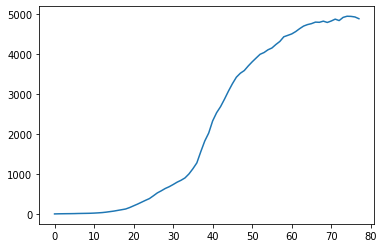

In [26]:
plt.plot(X)

## Вывод результатов применения теста Дики Фуллера

In [27]:
result = adfuller(X, maxlag=None, regression='ct', autolag='t-stat', store=False, regresults=True)
result[3].__dict__['resols'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     13.61
Date:                Wed, 21 Apr 2021   Prob (F-statistic):           1.70e-12
Time:                        03:45:48   Log-Likelihood:                -319.46
No. Observations:                  65   AIC:                             668.9
Df Residuals:                      50   BIC:                             701.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0376      0.016     -2.416      0.019      -0.069      -0.006
x2             0.5286      0.133      3.987      0.000       0.262       0.795
x3             0.2051      0.153      1.336      0.187      -0.103       0.513
x4             0.3008      0.156      1.930      0.059      -0.012       0.614
x5            -0.2232      0.161     -1.384      0.172      -0.547       0.101
x6             0.1496      0.170      0.879      0.383      -0.192       0.491
x7            -0.0062      0.179     -0.035      0.972      -0.366       0.354
x8             0.0715      0.180      0.397      0.693      -0.290       0.433
x9            -0.0929      0.182     -0.510      0.613      -0.459       0.273
x10           -0.0356      0.184     -0.194      0.847      -0.405       0.334
x11           -0.0748      0.181     -0.414      0.681      -0.438       0.289
x12           -0.0759      0.185     -0.411      0.683      -0.447       0.295
x13            0.3643      0.157      2.318      0.025       0.049       0.680
const         -5.8366     15.285     -0.382      0.704     -36.537      24.864
x14            2.9081      1.433      2.030      0.048       0.030       5.786
==============================================================================
Omnibus:                       11.802   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               13.075
Skew:                           0.830   Prob(JB):                      0.00145
Kurtosis:                       4.440   Cond. No.                     1.07e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
result

(-2.415800182202282,
 0.3712531830982564,
 {'1%': -4.105265484751935,
  '5%': -3.4803385352753753,
  '10%': -3.1678389485662266},
 <statsmodels.stats.diagnostic.ResultsStore at 0x1320571b640>)

# Сезонные модели

### Загрузка входных данных

In [29]:
dist = pd.read_csv('data/season.csv')
season = dist["liquor"].dropna()
season

0       480
1       467
2       514
3       505
4       534
       ... 
331    1776
332    1743
333    1728
334    1769
335    2431
Name: liquor, Length: 336, dtype: int64

### График процесса, его АКФ и ЧАКФ

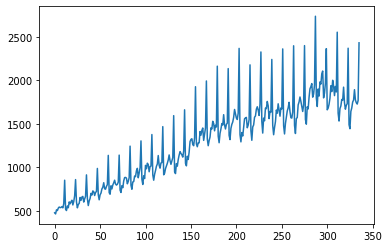

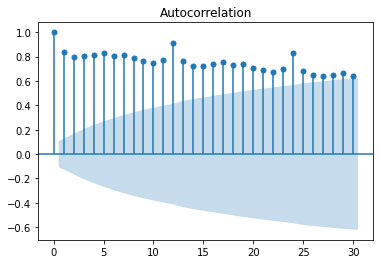

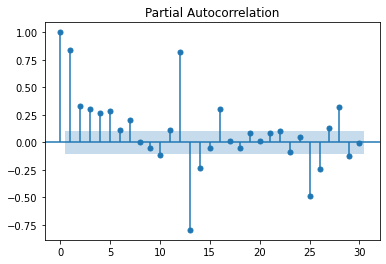

In [30]:
lagCount=30
plt.plot(season)
_ = plot_acf(season, lags=lagCount)
_ = plot_pacf(season, lags=lagCount)

## Удаление тренда

In [31]:
diff = list()
for i in range(1, len(season)):
	value = season[i] - season[i - 1]
	diff.append(value)

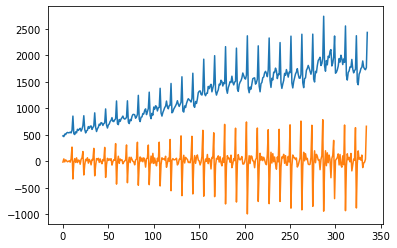

In [32]:
plt.plot(season, label='season')
plt.plot(diff, label='not trend')
plt.show()

### График процесса, его АКФ и ЧАКФ без тренда

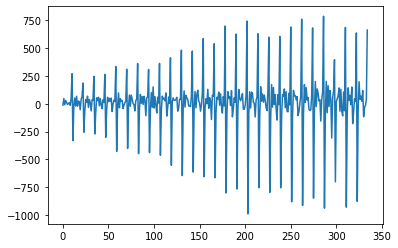

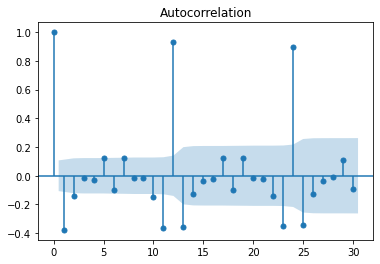

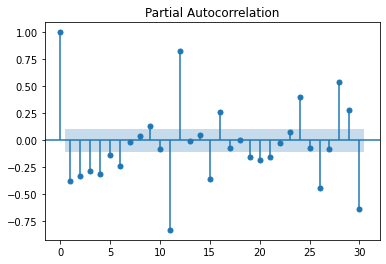

In [33]:
lagCountDiff = 30
plt.plot(diff)
_ = plot_acf(diff, lags=lagCountDiff)
_ = plot_pacf(diff, lags=lagCountDiff)

### Проанализируем графики АКФ и ЧАКФ, для определения максимальных порядков модели

### Проведём обучение для всех моделей, порядок которых ниже максимального порядка модели.

In [34]:

pSeason = [0, 1, 2]
qSeason = [0, 1, 2]
pOrder  = [0, 1, 2]
qOrder  = [0, 1, 2]
models = {}

for i in pOrder:
    for j in qOrder:
        for k in pSeason:
            for l in qSeason:
                if ((i, j ,k, l) == (0, 0, 0, 0)):
                    continue
                arimax = SARIMAX(np.array(diff), order=(i, 0, j), seasonal_order=(k, 0, l, 12), initialization='approximate_diffuse').fit()
                pVal = arimax.pvalues
                if all(i <= 0.05 for i in pVal):
                    models[i, j ,k, l] = arimax
                    # print(f'{arimax.summary()}')
# print(f'{models.keys()}')


### Количество моделей, имеющих значимые коэффициенты, то есть pVal < 0.05

In [35]:
print(f'{len(models.keys())}')

45


## Вычисление стандартной ошибки для оставшихся моделей

In [36]:
def standard_error(y, y_1, order):
    return np.sqrt(np.sum(np.square((y_1 - y))) / (len(y) - order))

In [37]:
def standard_error_model(train, test, model):
    k = max(model.model_orders['ar'], model.model_orders['ma'])
    standard_error_train = standard_error(train, model.predict(len(train)), k)
    standard_error_test = standard_error(test, model.forecast(len(test)), k)
    return standard_error_train, standard_error_test

In [38]:
m = {}

dict_se_train = {}
dict_se_test = {}
dict_aic = {}
dict_bic = {}
for name, model in models.items():
    tmp_dict = {}
    se_train, se_test = standard_error_model(season, diff, model)

    dict_se_train[name] = se_train
    dict_se_test[name] = se_test
    dict_aic[name] = model.aic
    dict_bic[name] = model.bic

    tmp_dict['SE Train'] = se_train
    tmp_dict['SE Test'] = se_test
    tmp_dict['AIC'] = model.aic
    tmp_dict['BIC'] = model.bic
    m[name] = tmp_dict

data = {
    'Model': list(m.keys()),
    'SE Train': list(dict_se_train.values()),
    'SE Test': list(dict_se_test.values()),
    'AIC': list(dict_aic.values()),
    'BIC': list(dict_bic.values())
}

df = pd.DataFrame.from_dict(data)
# df.set_index('Model')
dfAIC = df.sort_values("AIC")

### Таблица результатов моделей, отсортированных по критерию Акаике

In [39]:
dfAIC

,Model,SE Train,SE Test,AIC,BIC
32,"(2, 0, 1, 1)",1434.744250,478.906981,3638.247790,3657.318442
9,"(0, 1, 1, 1)",1439.528461,477.004269,3662.717513,3677.974035
15,"(0, 2, 1, 1)",1436.893046,477.986814,3664.312689,3683.383342
27,"(1, 2, 1, 1)",1441.706318,477.738817,3674.661382,3697.546165
20,"(1, 0, 1, 1)",1432.708272,476.848079,3689.894332,3705.150854
36,"(2, 1, 1, 1)",1436.326269,476.167711,3702.422476,3725.307259
34,"(2, 0, 2, 1)",1432.198820,481.954932,3703.215793,3726.100576
33,"(2, 0, 2, 0)",1435.944417,484.176329,3704.240094,3723.310746
16,"(0, 2, 2, 0)",1449.805486,482.926158,3717.560106,3736.630759
35,"(2, 1, 1, 0)",1422.145473,466.505001,3717.836857,3736.907509


## Анализ остатков моделей
Отсортировав все модели по критерию акаике, выберем первые 5
Построим их АКФ и ЧАКФ

SARIMAX (2, 0, 1, 1)


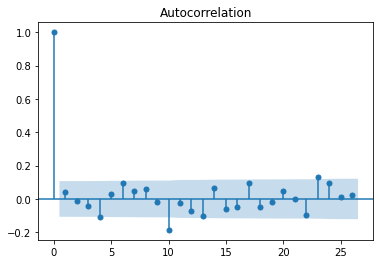

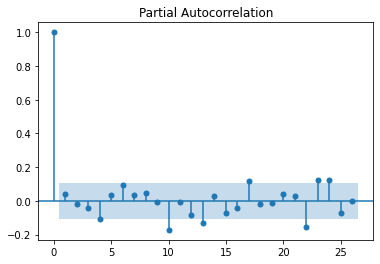

SARIMAX (0, 1, 1, 1)


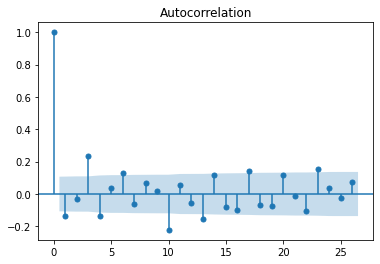

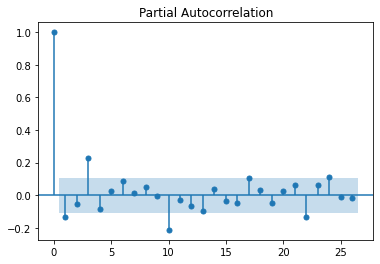

SARIMAX (0, 2, 1, 1)


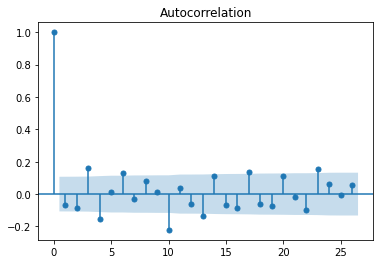

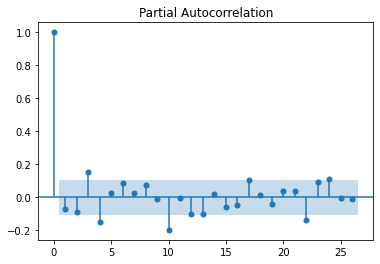

SARIMAX (1, 2, 1, 1)


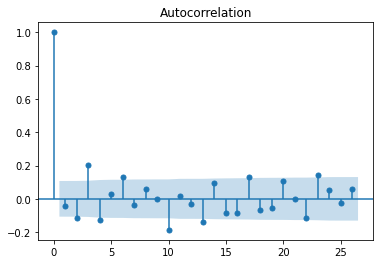

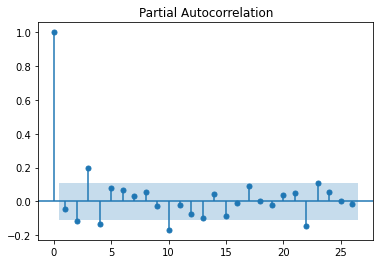

SARIMAX (1, 5, 1, 1)


KeyError: (1, 5, 1, 1)

In [40]:
print(f'SARIMAX (2, 0, 1, 1)')
m = models[(2, 0, 1, 1)]
_ = plot_acf(m.resid)
_ = plot_pacf(m.resid)
plt.show()

print(f'SARIMAX (0, 1, 1, 1)')
m = models[(0, 1, 1, 1)]
_ = plot_acf(m.resid)
_ = plot_pacf(m.resid)
plt.show()

print(f'SARIMAX (0, 2, 1, 1)')
m = models[(0, 2, 1, 1)]
_ = plot_acf(m.resid)
_ = plot_pacf(m.resid)
plt.show()

print(f'SARIMAX (1, 2, 1, 1)')
m = models[(1, 2, 1, 1)]
_ = plot_acf(m.resid)
_ = plot_pacf(m.resid)
plt.show()

print(f'SARIMAX (1, 5, 1, 1)')
m = models[(1, 5, 1, 1)]
_ = plot_acf(m.resid)
_ = plot_pacf(m.resid)
plt.show()